In [23]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from scipy.fft import fft, ifft, fftfreq
from matplotlib.pyplot import figure
import math as m
from segment import Segment
from func import *

In [73]:
# NUM_PORTS = 4
SIZE = 100
imp0 = 377
xs0 = 50  # source position for the segment 0
tau = 0.9
# kappa = 1j* m.sqrt(1-tau**2) # not working yet for complex number

maxTime = 4000

rings_no = 5
N_seg = rings_no*2

sources = Sources(rings_no)  #working for any number of rings
couplings = Couplings(rings_no, tau)

print(sources)
print(couplings)

ez_tab = np.zeros([N_seg, maxTime, SIZE], dtype=complex)

[[-1 -1]
 [ 0  3]
 [ 3  0]
 [ 2  5]
 [ 5  2]
 [ 4  7]
 [ 7  4]
 [ 6  9]
 [ 9  6]
 [-2 -2]]
[[0.9+0.j         0. +0.43588989j]
 [0.9+0.j         0. +0.43588989j]
 [0.9+0.j         0. +0.43588989j]
 [0.9+0.j         0. +0.43588989j]
 [0.9+0.j         0. +0.43588989j]
 [0.9+0.j         0. +0.43588989j]
 [0.9+0.j         0. +0.43588989j]
 [0.9+0.j         0. +0.43588989j]
 [0.9+0.j         0. +0.43588989j]
 [0.9+0.j         0. +0.43588989j]]


In [74]:
f_array = []

s_tab = np.zeros(maxTime, dtype=complex)

for ii in range(N_seg):
    f = Segment(SIZE)
    f_array.append(f)
# print(f_array)

lambda0 = 500e-9 
f_center = 3e8/lambda0
sigma_pulse = 3e-15 

print("freq. Hz", f_center) 


for qTime in range(maxTime):
    s = cosMod(qTime, maxTime, complex_signal=True, f0=f_center, sigma=sigma_pulse) 
    s_tab[qTime] = s
    
    for ii in range(N_seg):
        s1 = sources[ii][0]
        s2 = sources[ii][1]
        tau_ = couplings[ii][0]
        kappa_ = couplings[ii][1]
        
        xs = xs0
        if (sources[ii][0] == -1):
            s_new = s   
            xs = xs0
        elif (sources[ii][0] == -2):
            s_new = 0. 
        else:
            s_new = tau_*f_array[s1].ez[-1] + kappa_*f_array[s2].ez[-1]
            xs = 2  
            
        # print(s_new)
        
        f_array[ii].hy_update()
        f_array[ii].hy_sources(s_new,xs)
        f_array[ii].ez_update()
        f_array[ii].ez_sources(s_new,xs)
        

        ez_tab[ii,qTime,:] = f_array[ii].ez[:]   

for ii in range(N_seg):
    filename = f"data/ez_tab_{ii:06d}.csv"  # e.g., ez_tab_0000.txt, ez_tab_0001.txt, ...
    np.savetxt(filename, ez_tab[ii, :, :], delimiter=",")

freq. Hz 600000000000000.0


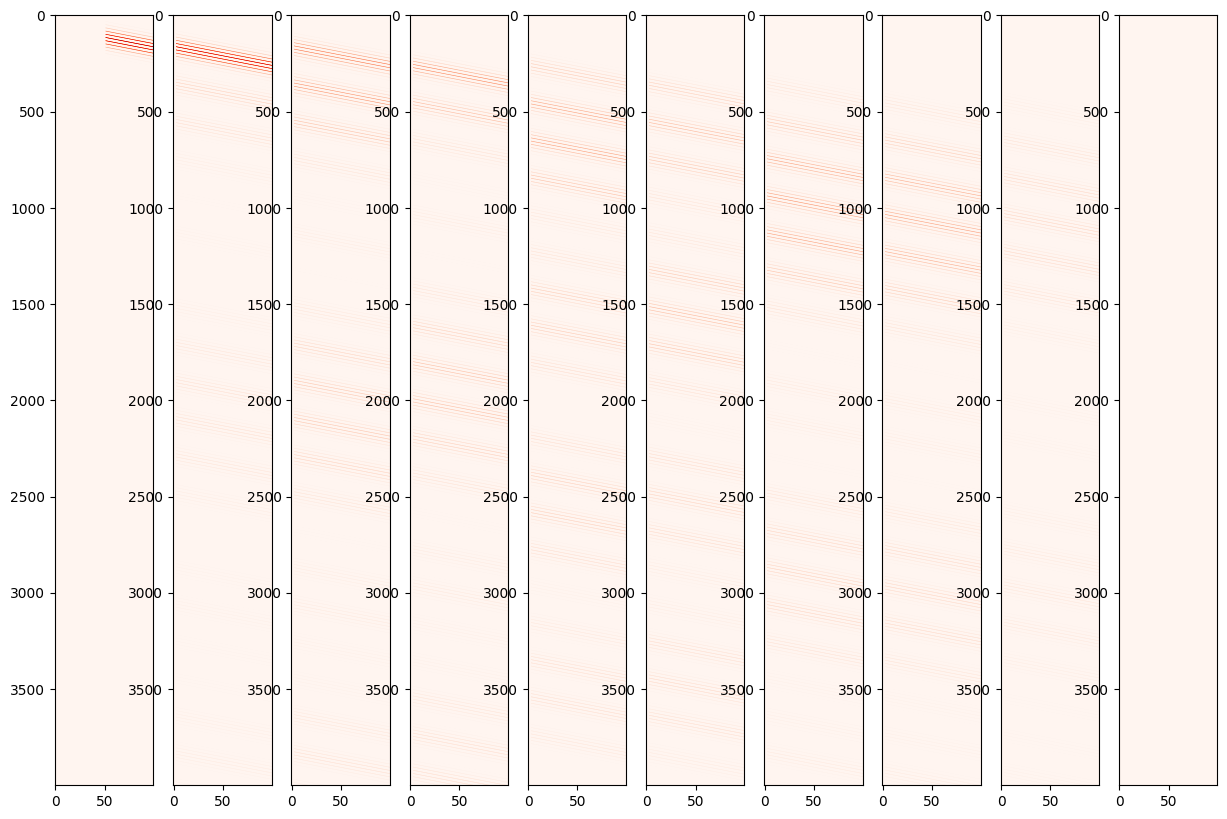

In [75]:
f, ax = plt.subplots(1,N_seg, figsize=(15,10)) 

vmax_val = np.max(np.real(ez_tab[0,:,:]))

for ii in range(N_seg):
    ax[ii].imshow(np.real(ez_tab[ii,:,:]), aspect='auto', vmin = 0, vmax = vmax_val , cmap = 'Reds')

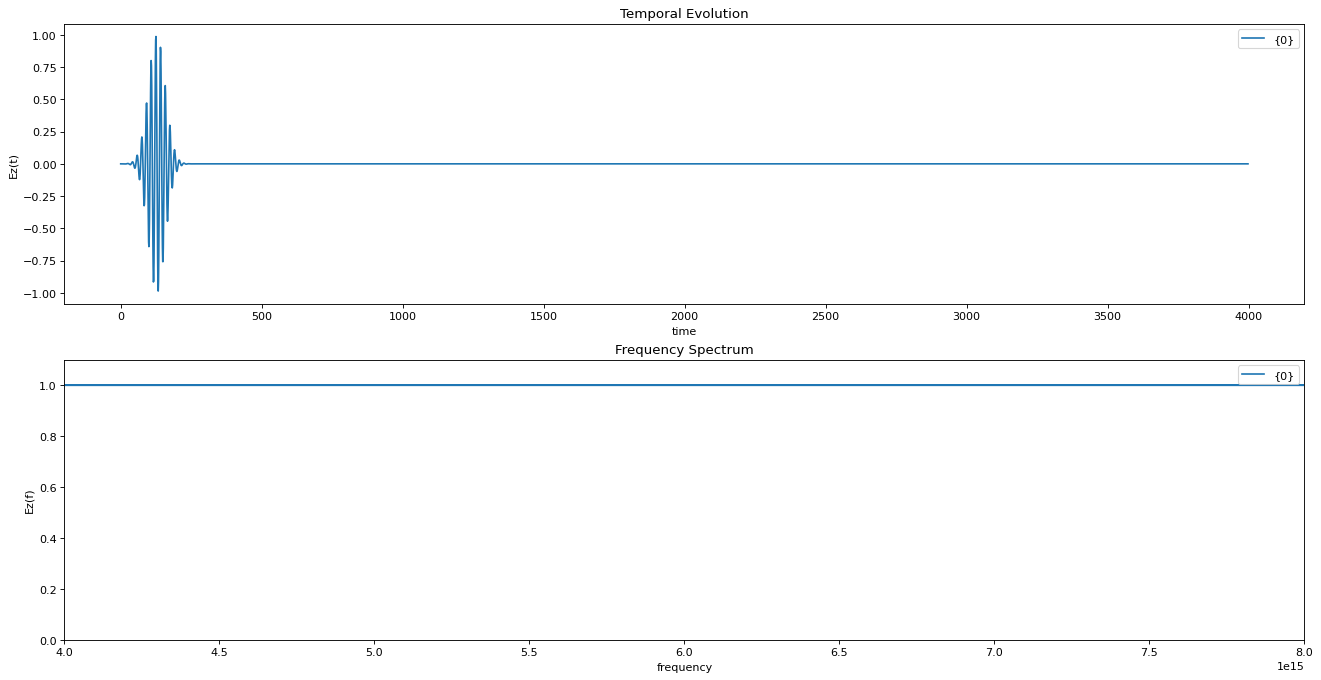

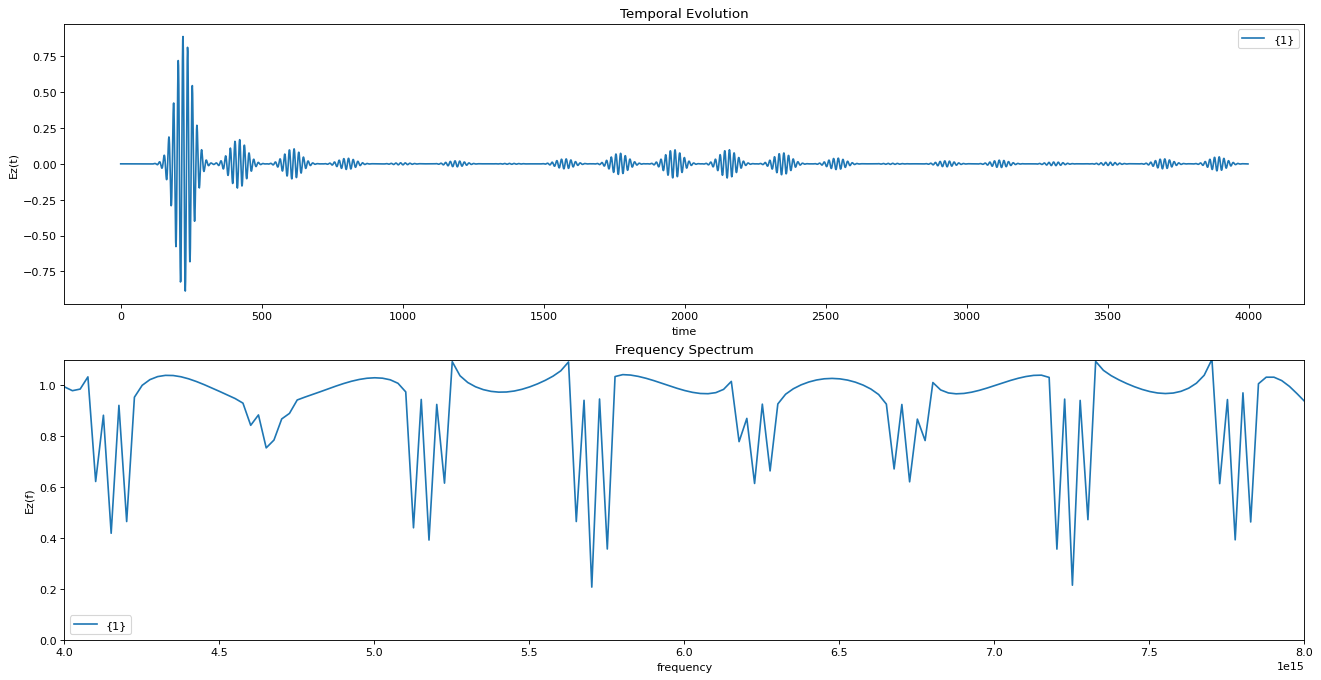

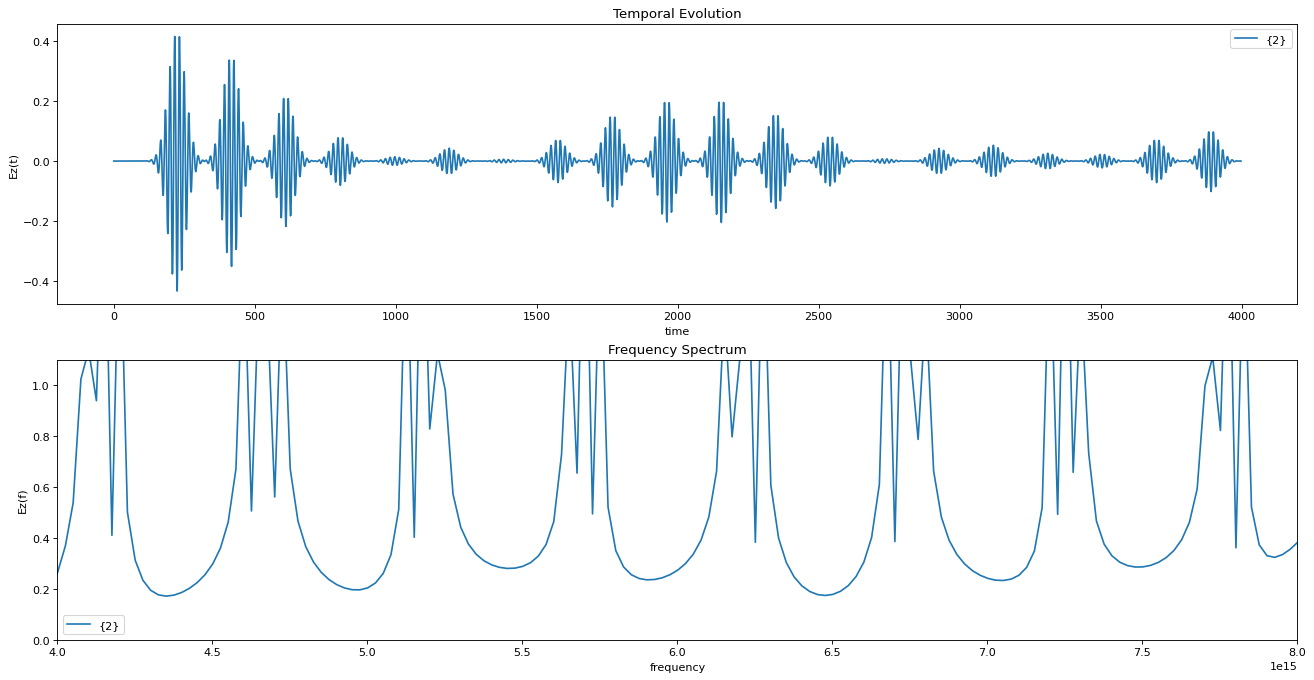

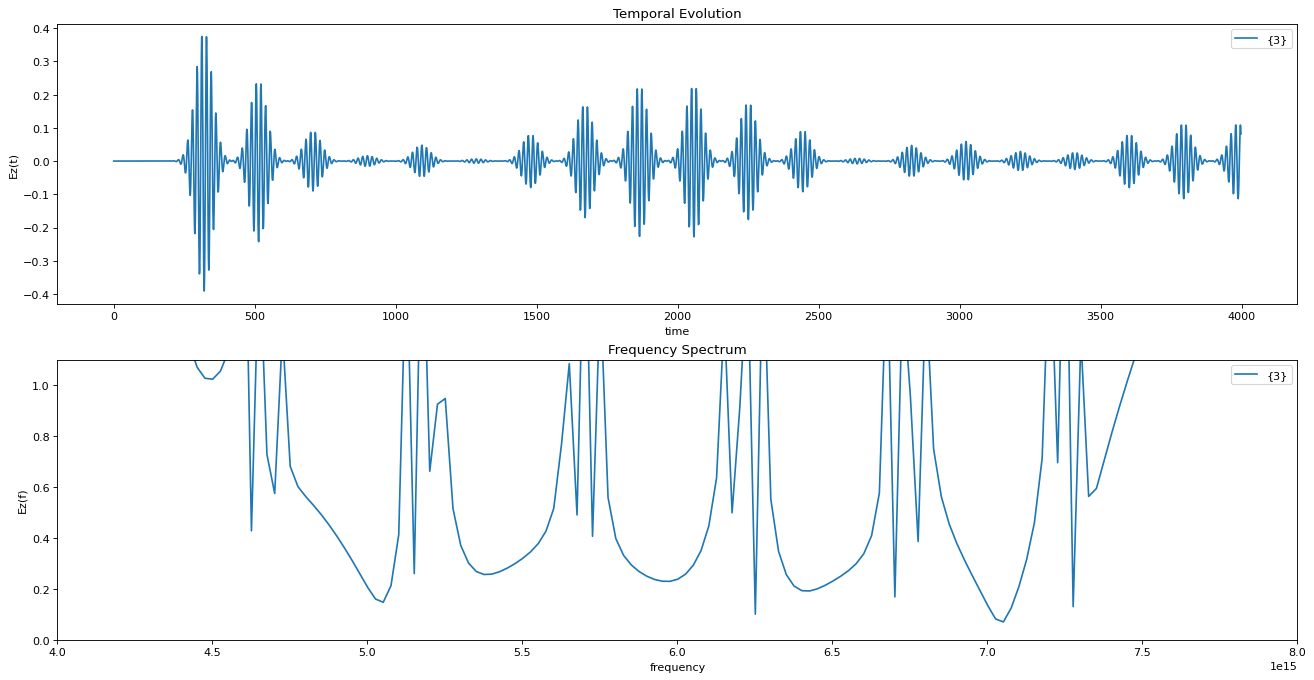

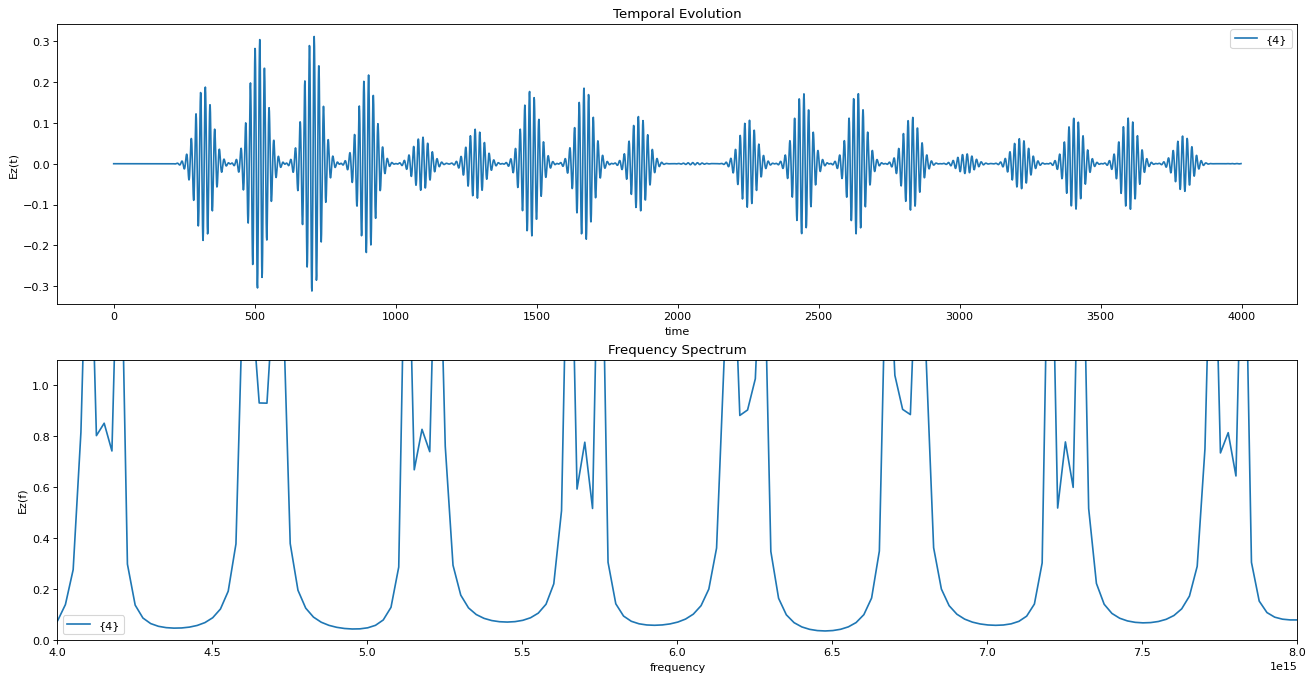

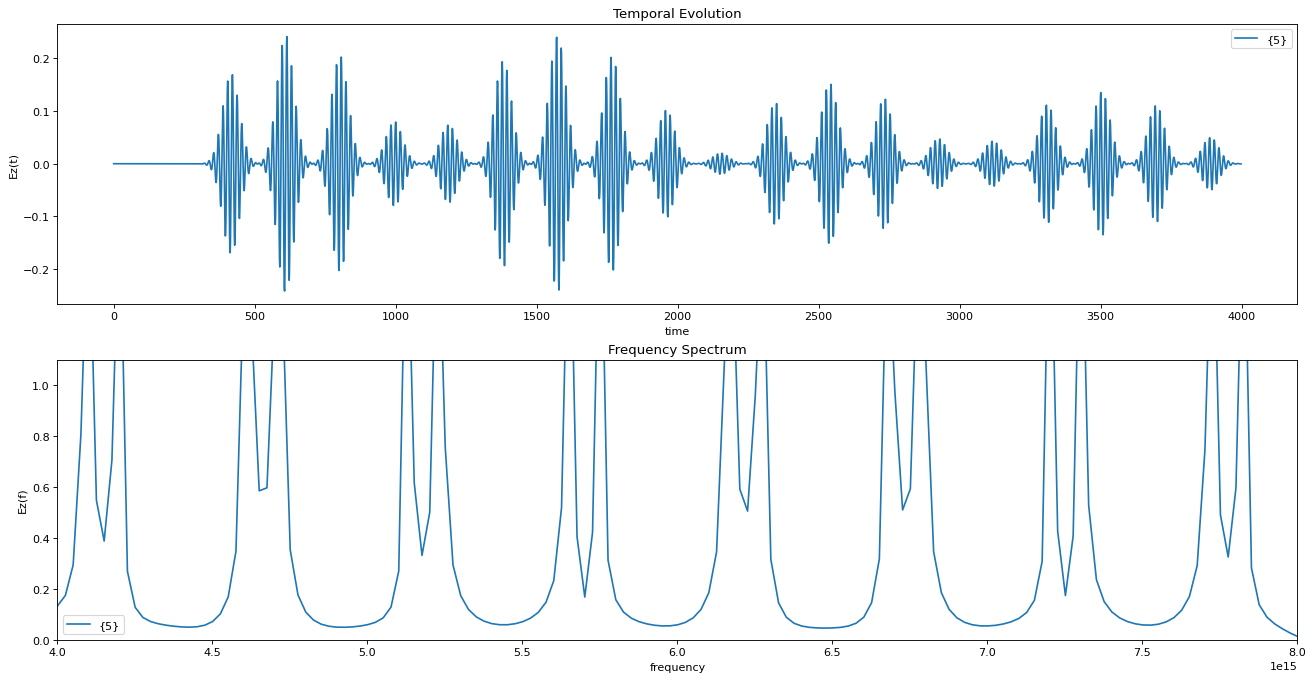

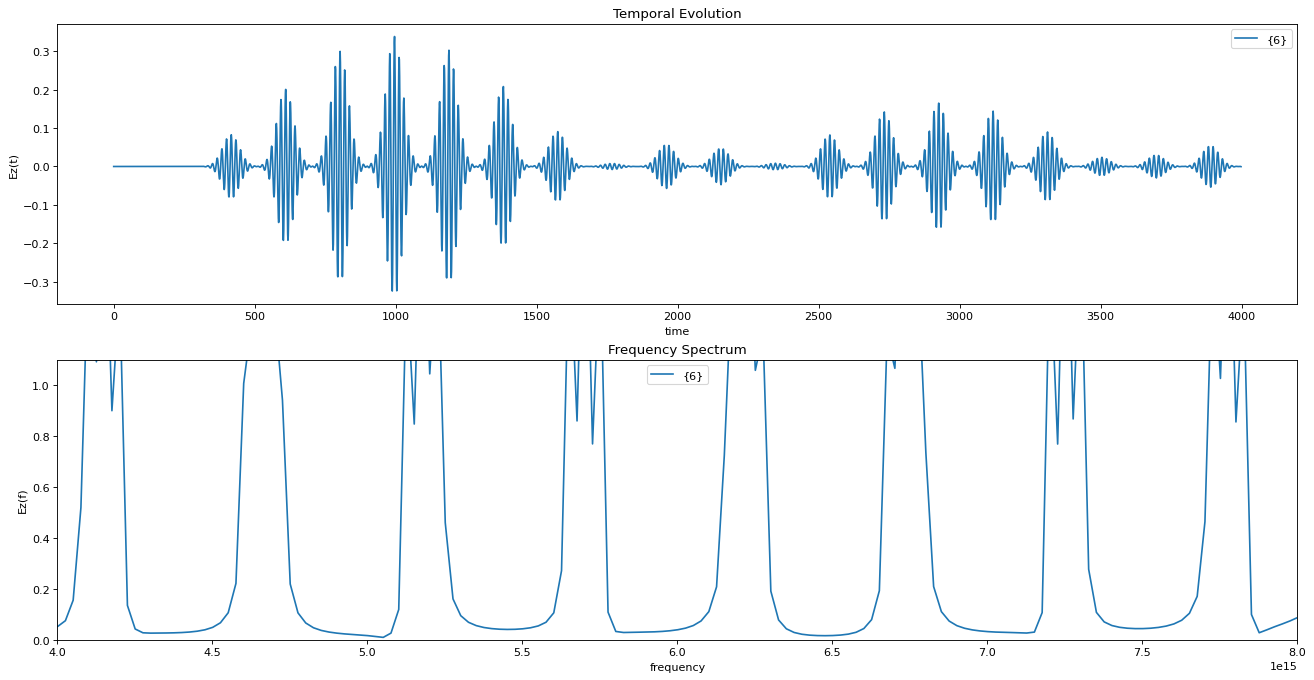

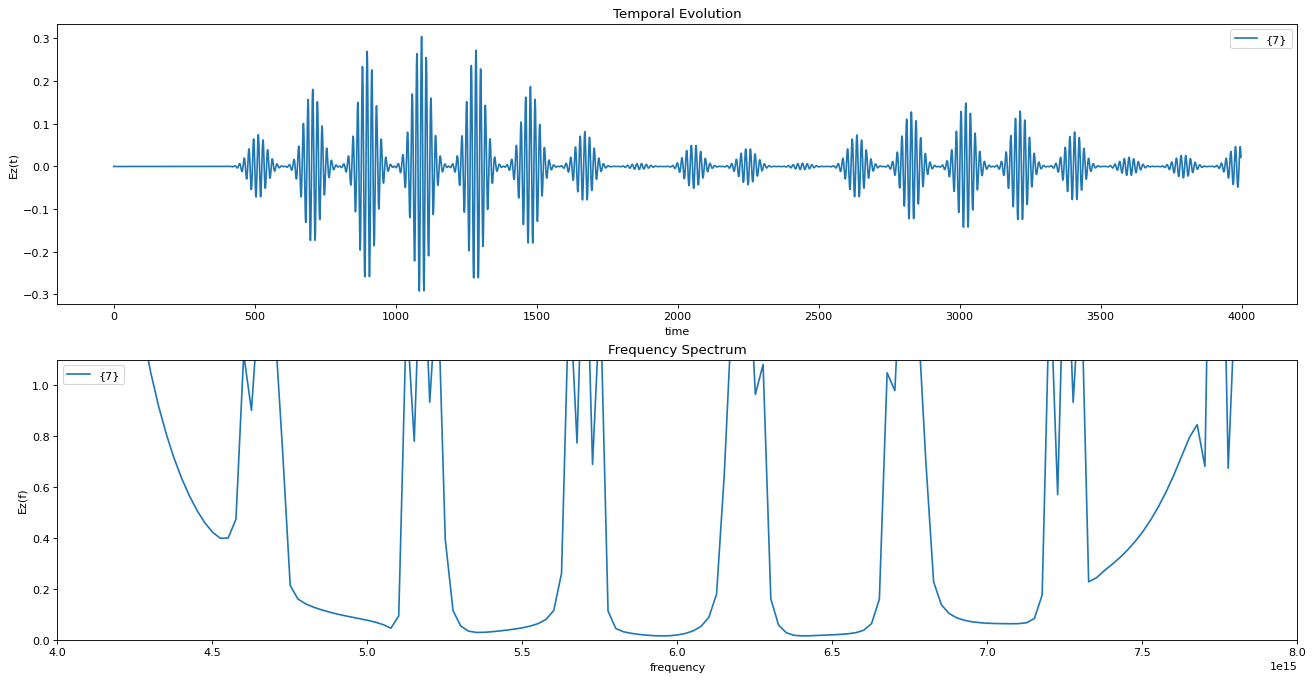

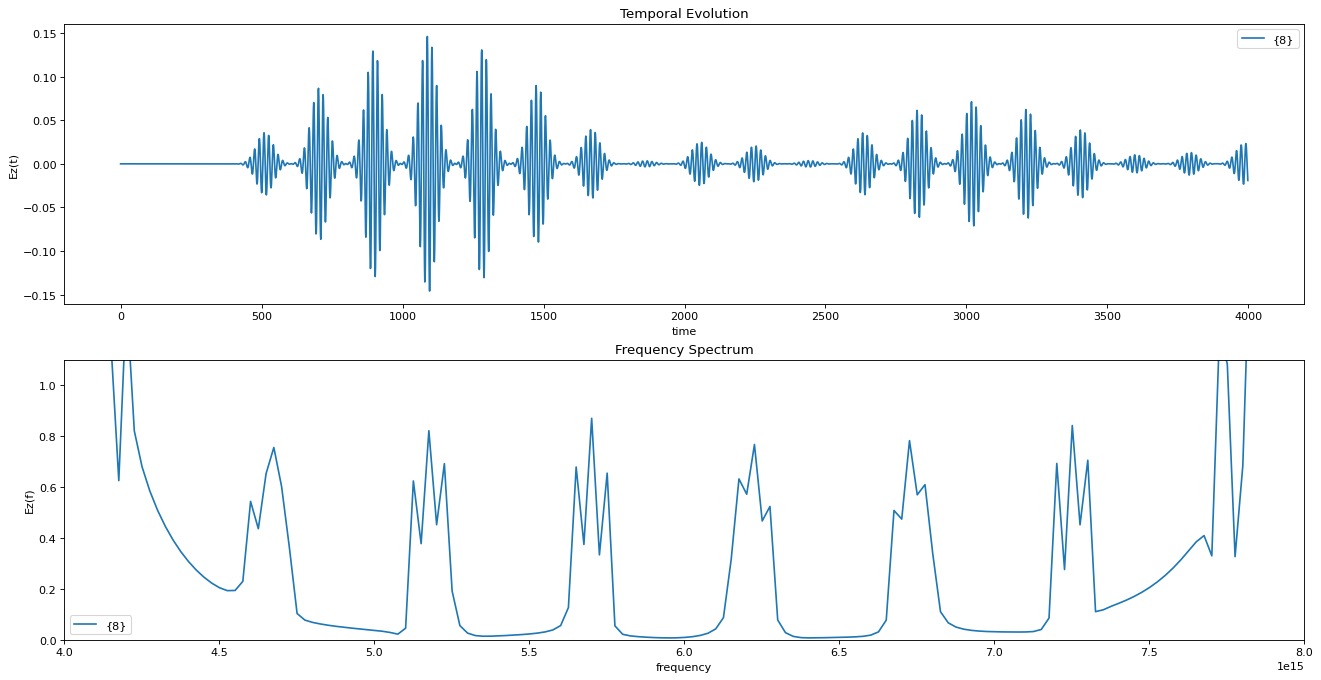

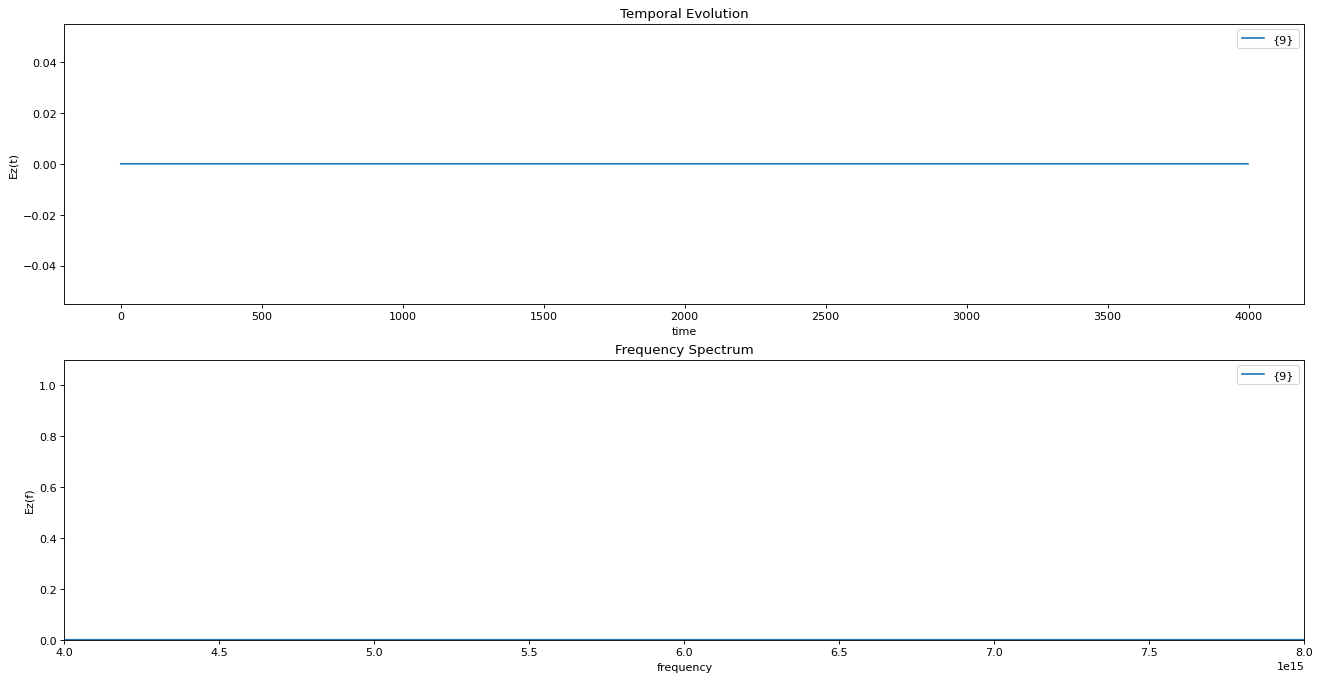

In [76]:
Ez = np.zeros((maxTime-1,SIZE), dtype=complex)
yf = np.zeros((maxTime-1,SIZE), dtype=complex)
N = maxTime-1
dt = 1e-17
xf = fftfreq(N,dt)
# xf = 2* np.pi* xf

for ii in range(N_seg):
    filename = f"data/ez_tab_{ii:06d}.csv"
    df = pd.read_csv(filename)
    # print(df.shape)
    Ez[:,ii] = df.iloc[:,60]   #all rows of the 10th spatial point
    # Ez[:,ii] -= np.mean(Ez[:,ii])
    
    yf[:,ii] = abs(fft(Ez[:,ii]))
    
    # print("Min:", np.min(Ez[:,ii]), "Max:", np.max(Ez[:,ii]))

    
    #accessing particular columns - all elements(all time steps for a particular spatial coordinate.)
x = range(len(df.iloc[0,:])) 
# print(x)   

for ii in range(N_seg):
    figure(figsize=(20,10), dpi=80)
    plt.subplot(2,1,1)
    plt.plot(np.real(Ez[:,ii]), label={ii})
    plt.title("Temporal Evolution")
    plt.xlabel("time")
    plt.ylabel("Ez(t)")
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(xf,np.abs(yf[:,ii]/np.abs(yf[:,0])), label={ii})
    plt.xlim([0.4e16,0.8e16])
    plt.ylim([0,1.1])
    plt.title("Frequency Spectrum")
    plt.xlabel("frequency")
    plt.ylabel("Ez(f)")
    plt.legend()
    plt.show()

In [79]:
# Parameters
ez_tab_ordered = np.zeros((N_seg, maxTime, SIZE), dtype = complex)
for ring in range(rings_no):
    if ring%2 == 0: #even segment
        ez_tab_ordered[(2*ring),:,:] = ez_tab[2*ring + 1,:,:]
        ez_tab_ordered[(2*ring)+1,:,:] = ez_tab[2*ring,:,:]
    else:
        ez_tab_ordered[(2*ring),:,:] = ez_tab[2*ring,:,:]
        ez_tab_ordered[(2*ring)+1,:,:] = ez_tab[2*ring + 1,:,:]
        
print(np.shape(ez_tab_ordered))


for tp in range(4000,5000,100):
    ez_tab_tp = ez_tab_ordered[:,tp,:]      
    plot_field_ring(ez_tab_tp, rings_no)

(10, 4000, 100)


IndexError: index 4000 is out of bounds for axis 1 with size 4000

In [21]:
#while coupling I used different indices so in order for the arc plotting function to stack the electric fields in the order they were coupled, I made this logic.

for ring in range(rings_no):
    if ring%2 ==0:
        print(2*ring, 2*ring +1)
        print(2*ring+1, 2*ring)
    else:
        print(2*ring, 2*ring +1)
        print(2*ring, 2*ring +1)

0 1
1 0
2 3
2 3
4 5
5 4
